In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import tensorflow as tf
import math
import time

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [3]:
# Import and organize data. Use only FSR data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d1 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)

In [69]:
np.shape(data)

(72, 7000, 12)

In [5]:
y = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [6]:
len(y)

72

In [7]:
# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

In [ ]:
# This feature takes the max of each column, takes the data point [change_factor] ms after that, and then normalizes 
# the difference

def change_in_max(column, change_factor):
    max_index = np.argmax(column)
    minus_change_index = max_index - change_factor
    if minus_change_index > 0:
        minus_change_value = column[minus_change_index]
    else:
        minus_change_index = max_index + change_factor
        minus_change_value = column[minus_change_index]
    diff = np.max(column) - minus_change_value
    normalized = diff/np.std(column)
    return normalized

In [ ]:
# This function takes all 72 data points of size (7001,16) and puts them into feature-engineered array (all features).
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent, change_in_max_change_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 6
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = change_in_max(column,change_in_max_change_factor)
            D[5,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

In [8]:
# Condense data into averages over a specified number of data points

def condense(array, condense_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
    return condensed_data

In [9]:
# Takes the max of all features from the 16 datapoints. Output is 72 sets of 1 by 6 data, where each of the 6 points
# is the max of each feature from the set. 

def everything_max(array):
    len_dataset, num_features, num_datapoints = np.shape(array)
    maxed_data = np.zeros((len_dataset, 1, num_features))
    for i in range(len_dataset):
        datapoint = array[i]
        D = np.zeros((1, num_features))
        for j in range(num_features):
            D[0,j] = max(datapoint[:,j])
        maxed_data[i] = D
    return maxed_data

In [11]:
# Normalize and feature-ify the data
normalized_data = data/np.max(data)
normalized_featured_data = features(normalized_data,.75,50)
np.shape(normalized_featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

(72, 6, 12)

In [33]:
# Make dataset that only has max of each feature
maxed_data = everything_max(normalized_featured_data)

In [34]:
# Turn 3D array into 2D array
np.shape(maxed_data)

(72, 1, 6)

In [241]:
# Turn 3D array into 2D array. Put features together later if possible?

def two_d(data):
    len_data, num_cols, num_points = np.shape(data)
    data_new = np.zeros((len_data, num_cols*num_points))
    for i in range(len_data):
        current = data[i]
        for j in range(num_cols):
            for k in range(num_points):
                data_new[i][num_points*j+k] = current[j][k]
    return data_new

In [249]:
def add_probs(array):
    new_probs = np.zeros((4, 4))
    for i in [0,2,4,6]:
        ind=np.int(i/2)
        for j in range(4):
            new_probs[ind][j] = array[i][j]+array[i+1][j]
    new_probs=np.transpose(new_probs)*100
    return new_probs/2

In [243]:
# Compare normalized vs. non-normalized data with 100 estimators

# non-normalized data
x = two_d(data)
x_train, y_train = x[:32], y[:32]
x_valid, y_valid = x[32:64], y[32:64]
x_train_valid, y_train_valid = x[:64], y[:64]
x_test, y_test = x[64:], y[64:]

In [244]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train_valid, y_train_valid)
clf_probs1 = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

In [245]:
# normalized data
x = two_d(normalized_data)
x_train, y_train = x[:32], y[:32]
x_valid, y_valid = x[32:64], y[32:64]
x_train_valid, y_train_valid = x[:64], y[:64]
x_test, y_test = x[64:], y[64:]

In [246]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train_valid, y_train_valid)
clf_probs2 = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

In [250]:
new_probs1 = add_probs(clf_probs1)
new_probs2 = add_probs(clf_probs2)
new_probs1

array([[51. ,  0.5,  4. ,  1. ],
       [16.5, 84.5, 24.5, 28.5],
       [15.5, 10.5, 51. , 25. ],
       [17. ,  4.5, 20.5, 45.5]])

In [253]:
new_probs2

array([[48.5,  2. ,  2.5,  4. ],
       [22.5, 81. , 22. , 24.5],
       [ 9. , 11.5, 54. , 21. ],
       [20. ,  5.5, 21.5, 50.5]])

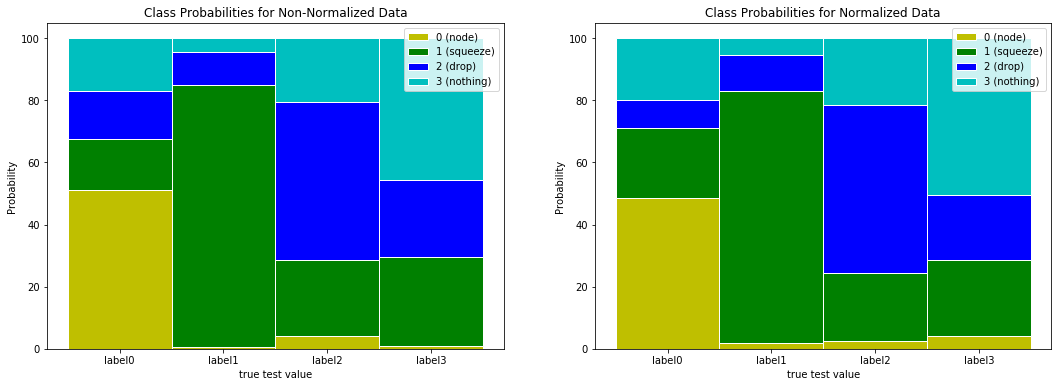

In [266]:
N = 4
label0 = new_probs1[0]
label1 = new_probs1[1]
label2 = new_probs1[2]
label3 = new_probs1[3]

 
# The position of the bars on the x-axis
r = [0,1,2,3]
 
# Names of group and bar width
names = ['label0','label1','label2','label3']
barWidth = 1
 
fig= plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities for Non-Normalized Data')

# Second subplot

plt.subplot(1, 2, 2)

label0 = new_probs2[0]
label1 = new_probs2[1]
label2 = new_probs2[2]
label3 = new_probs2[3]
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities for Normalized Data')

plt.show()


In [267]:
clf_probs

array([[0.723, 0.072, 0.007, 0.198],
       [0.209, 0.317, 0.314, 0.16 ],
       [0.016, 0.807, 0.152, 0.025],
       [0.01 , 0.845, 0.093, 0.052],
       [0.067, 0.249, 0.547, 0.137],
       [0.022, 0.267, 0.453, 0.258],
       [0.021, 0.265, 0.29 , 0.424],
       [0.012, 0.262, 0.226, 0.5  ]])

In [282]:
# Compare feature-ified vs. non-feature-ified data

# non-featured data
x = normalized_data
x_train, y_train = x[:32], y[:32]
x_valid, y_valid = x[32:64], y[32:64]
x_train_valid, y_train_valid = x[:64], y[:64]
x_test, y_test = x[64:], y[64:]

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train_valid, y_train_valid)
clf_probs1 = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

#featured data
x = normalized_featured_data
x_train, y_train = x[:32], y[:32]
x_valid, y_valid = x[32:64], y[32:64]
x_train_valid, y_train_valid = x[:64], y[:64]
x_test, y_test = x[64:], y[64:]

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train_valid, y_train_valid)
clf_probs2 = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

In [283]:
new_probs1 = add_probs(clf_probs1)
new_probs2 = add_probs(clf_probs2)

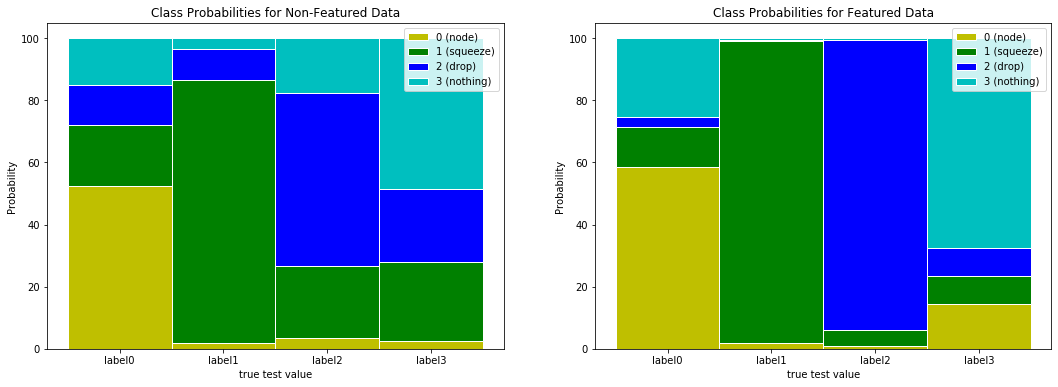

In [284]:
N = 4
label0 = new_probs1[0]
label1 = new_probs1[1]
label2 = new_probs1[2]
label3 = new_probs1[3]

 
# The position of the bars on the x-axis
r = [0,1,2,3]
 
# Names of group and bar width
names = ['label0','label1','label2','label3']
barWidth = 1
 
fig= plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities for Non-Featured Data')

# Second subplot

plt.subplot(1, 2, 2)

label0 = new_probs2[0]
label1 = new_probs2[1]
label2 = new_probs2[2]
label3 = new_probs2[3]
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities for Featured Data')

plt.show()


In [321]:
condensed_data = condense(data,1000)

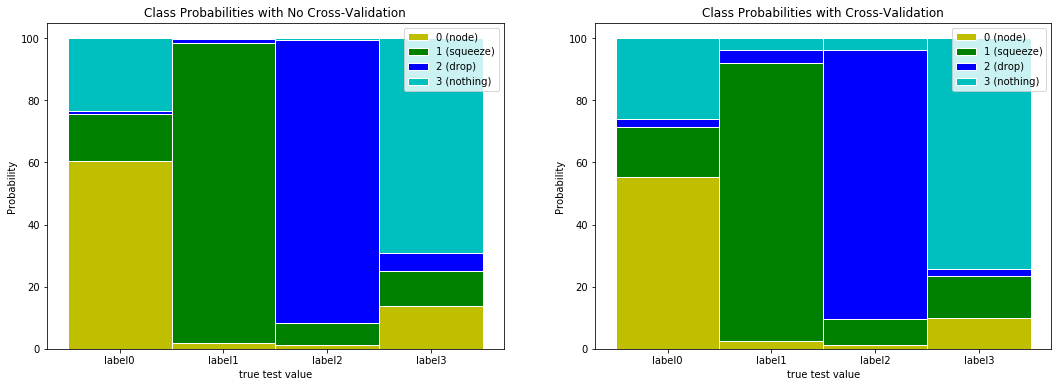

In [333]:
# Feature-engineered data: cross-validation vs. not
# This compares the classifier when trained on 64 data points and tested on the last 8 vs. when it is trained on 
# the first 32 data points, validated on the next 32 data points, and tested on the last 8

# Feature-engineered data
x = normalized_featured_data
x_train, y_train = x[:32], y[:32]
x_valid, y_valid = x[32:64], y[32:64]
x_train_valid, y_train_valid = x[:64], y[:64]
x_test, y_test = x[64:], y[64:]

# Train uncalibrated random forest classifier on whole train and validation data and evaluate on test data
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x_train_valid, y_train_valid)
clf_probs1 = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate on test data
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x_train, y_train)
clf_probs2 = clf.predict_proba(x_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(x_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(x_test)
sig_score = log_loss(y_test, sig_clf_probs)

new_probs1 = add_probs(clf_probs1)
new_probs2 = add_probs(sig_clf_probs)

N = 4
label0 = new_probs1[0]
label1 = new_probs1[1]
label2 = new_probs1[2]
label3 = new_probs1[3]

 
# The position of the bars on the x-axis
r = [0,1,2,3]
 
# Names of group and bar width
names = ['label0','label1','label2','label3']
barWidth = 1
 
fig= plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities with No Cross-Validation')

# Second subplot

plt.subplot(1, 2, 2)

label0 = new_probs2[0]
label1 = new_probs2[1]
label2 = new_probs2[2]
label3 = new_probs2[3]
    
plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
plt.xticks(r, names)
plt.xlabel("true test value")
plt.ylabel('Probability')
plt.title('Class Probabilities with Cross-Validation')

plt.show()


In [331]:
clf_probs1

array([[0.63 , 0.15 , 0.018, 0.202],
       [0.632, 0.131, 0.   , 0.237],
       [0.002, 0.991, 0.007, 0.   ],
       [0.027, 0.956, 0.01 , 0.007],
       [0.026, 0.107, 0.856, 0.011],
       [0.005, 0.024, 0.968, 0.003],
       [0.189, 0.22 , 0.015, 0.576],
       [0.056, 0.008, 0.077, 0.859]])

In [332]:
sig_clf_probs

array([[0.41601623, 0.16782076, 0.02694017, 0.38922284],
       [0.62211785, 0.13310302, 0.02383474, 0.22094439],
       [0.02164466, 0.91293892, 0.02917326, 0.03624316],
       [0.02748888, 0.88363127, 0.05087031, 0.03800954],
       [0.01382012, 0.11273095, 0.83525022, 0.0381987 ],
       [0.01215731, 0.05069029, 0.90258155, 0.03457085],
       [0.13018501, 0.21179449, 0.02335211, 0.63466839],
       [0.0880131 , 0.0630707 , 0.02887581, 0.82004039]])

In [ ]:

# Train uncalibrated random forest classifier on whole train and validation data and evaluate on test data
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x_train_valid, y_train_valid)
clf_probs = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

In [66]:
# Train random forest classifier, calibrate on validation data and evaluate on test data

clf = RandomForestClassifier(n_estimators=5000)
clf.fit(x_train, y_train)
clf_probs = clf.predict_proba(x_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(x_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(x_test)
sig_score = log_loss(y_test, sig_clf_probs)

[0, 0, 1, 1, 2, 2, 3, 3]

In [50]:
sig_clf_probs

array([[0.20707208, 0.55427376, 0.09389592, 0.14475825],
       [0.15935834, 0.40665798, 0.04456718, 0.3894165 ],
       [0.0138608 , 0.72535904, 0.2246393 , 0.03614086],
       [0.03922449, 0.78543352, 0.12835306, 0.04698893],
       [0.01571766, 0.40308116, 0.54230883, 0.03889234],
       [0.0148907 , 0.66512093, 0.284362  , 0.03562637],
       [0.17870746, 0.36079511, 0.04398887, 0.41650856],
       [0.06845249, 0.24791569, 0.02938343, 0.65424839]])

In [194]:
y_test

[0, 0, 1, 1, 2, 2, 3, 3]